<a href="https://colab.research.google.com/github/teoalcdor/tfg_teoalcdor/blob/main/fcn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FCN

En este notebook vamos a utilizar una FCN para abordar el problema planteado en nuestro dataset de segmentación. Vamos a congelar la backbone y a entrenar de cero la cabeza.

## Librerías

Comenzamos cargando instalando las librerías necesarias:

In [ ]:
!pip install torchinfo

In [ ]:
import cv2
from glob import glob
from google.colab import drive
import numpy as np
from numpy import inf
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary
from torchvision import models, transforms
from torchvision.models.segmentation.fcn import FCNHead
from torchvision.ops import nms
import tqdm
import copy

In [ ]:
%matplotlib inline

Tratamos de utilizar la GPU

In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)

cuda


## Funciones Auxiliares

Definimos las funciones que vamos a utilizar para el entrenamiento y la representación de los resultados:

In [ ]:
def segmentation_loss(preds, targets):
    """
    Pérdida de entropía cruzada binaria y accuracy de segmentacion para un
    batch.
    """
    loss = nn.CrossEntropyLoss()(preds, targets)
    accuracy = (torch.max(preds, 1)[1] == targets).float().mean()
    return loss, accuracy


def train_batch(model, data, optimizer, criterion):
    """
    Entrena el modelo en un batch.
    """

    model.train() # Modo entrenamiento

    # Obtenemos la prediccion con propagacion hacia delante (logits)
    ims, masks = data
    _masks = model(ims)["out"]

    # Obtenemos la perdida
    loss, accuracy = criterion(_masks, masks)

    # Calculamos el gradiente de la perdida con retropropagacion
    loss.backward()

    # Hacemos un paso del metodo del gradiente
    optimizer.step()

    # Vaciamos el optimizador de la informacion del gradiente
    optimizer.zero_grad()

    return loss.item(), accuracy.item() # Retornamos el numero, no un tensor


@torch.no_grad()
def validate_batch(model, data, criterion):
    """
    Calcula la pérdida del modelo en el conjunto de validación.
    """

    model.eval() # Modo inferencia

    # Obtenemos la prediccion con propagacion hacia delante (logits)
    ims, masks = data
    _masks = model(ims)["out"]

    # Obtenemos la perdida
    loss, accuracy = criterion(_masks, masks)

    return loss.item(), accuracy.item()


def train_model(model, optimizer, train_dataloader, val_dataloader, criterion, epochs=10):
    """
    Entrena el modelo, implementando un mecanismo que actúa como early stopping basado en
    la accuracy en validación. Devuelve también las pérdida y accuracy encontradas en
    los conjuntos de entrenamiento y valiación durante el entrenamiento.
    """

    # Inicializamos las listas con las perdidas y accuracies
    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []

    # Inicializamos el mecanismo de early stopping
    best_model = {
        "model_state_dict": None,
        "optimizer_state_dict": None,
        "epoch": None,
        "max_val_accuracy": -1
    }

    for epoch in range(epochs):

        # Regristramos el momento de comienzo de la epoch
        year, month, day, h, m, s = map(lambda x : x.rjust(2, "0"),
                                          time.strftime("%y %m %d %H %M %S")
                                          .split())
        time_stamp = f"{day}/{month}/{year} {h}:{m}:{s}"
        start = time.time()
        print("=" * 80)
        print(f"Epoch: {epoch + 1} - Started: {time_stamp}")

        # Inicializamos las listas con las perdidas y accuracies de la epoch
        train_epoch_loss, val_epoch_loss = [], []
        train_epoch_accuracy, val_epoch_accuracy = [], []

        # Entrenamos el modelo con minibatch
        _n = len(train_dataloader)
        for _, inputs in tqdm.tqdm(enumerate(train_dataloader), total=_n, desc="- Training"):
            loss, accuracy = train_batch(model, inputs, optimizer, criterion)
            train_epoch_loss.append(loss)
            train_epoch_accuracy.append(accuracy)

        # Calculamos la perdida y la accuracy sobre el conjunto de validacion
        _n = len(val_dataloader)
        for _, inputs in tqdm.tqdm(enumerate(val_dataloader), total=_n, desc="- Validation"):
            loss, accuracy = validate_batch(model, inputs, criterion)
            val_epoch_loss.append(loss)
            val_epoch_accuracy.append(accuracy)

        # Actualizamos las perdidas y accuracies
        train_losses.append(np.mean(train_epoch_loss))
        train_accuracies.append(np.mean(train_epoch_accuracy))
        val_losses.append(np.mean(val_epoch_loss))
        val_accuracies.append(np.mean(val_epoch_accuracy))

        # Ponemos en marcha el mecanismo de early stopping
        if val_accuracies[-1] > best_model["max_val_accuracy"]:
            best_model["max_val_accuracy"] = val_accuracies[-1]
            best_model["model_state_dict"] = copy.deepcopy(model.state_dict())
            best_model["optimizer_state_dict"] = copy.deepcopy(optimizer.state_dict())
            best_model["epoch"] = epoch + 1

        # Regristramos el momento de comienzo de la epoch
        end = time.time()
        year, month, day, h, m, s = map(lambda x : x.rjust(2, "0"),
                                        time.strftime("%y %m %d %H %M %S")
                                        .split())
        time_stamp = f"{day}/{month}/{year} {h}:{m}:{s}"

        print(f"Epoch: {epoch + 1} - Ended: {time_stamp} - Duration: {round(end - start, 2)}s")
        print()

        # Imprimimos estadisticas de la epoch para un mejor seguimiento
        print(f"Training Loss: {train_losses[-1]} - Validation Loss: {val_losses[-1]}")
        print(f"Training Accuracy: {train_accuracies[-1]} - Validation Accuracy: {val_accuracies[-1]}")
        print("=" * 80)
        print()

    return train_losses, train_accuracies, val_losses, val_accuracies, best_model


def plot_training_results(train_losses, val_losses,
                          train_accuracies, val_accuracies, title):
    """
    Representa la pérdida y accuracy del modelo en el entrenamiento sobre
    los conjuntos de entrenamiento y validación.
    """

    # Diccionario con las perdidas
    losses_results = pd.DataFrame(
        {f"Entrenamiento": train_losses,
         f"Validación": val_losses})

    # Diccionario con las accuracies
    accuracies_results = pd.DataFrame(
        {f"Entrenamiento": train_accuracies,
         f"Validación": val_accuracies})

    with sns.axes_style("whitegrid"):
        fig, axs = plt.subplots(1, 2, figsize=(12, 4))

        # Grafica de las perdidas
        losses_results_plot = sns.lineplot(data=losses_results, ax = axs[0])
        axs[0].set_ylabel("Pérdida", fontsize=17)
        axs[0].set_xlabel("Epochs", fontsize=17)
        axs[0].set_xticks([0, 4, 9, 14, 19, 24])
        axs[0].set_xticklabels([1, 5, 10, 15, 20, 25], fontsize=12)
        axs[0].tick_params(axis='y', labelsize=12)

        # Grafica de las accuracies
        accuracies_results_plot = sns.lineplot(data=accuracies_results, ax = axs[1])
        axs[1].set_xticks([0, 4, 9, 14, 19, 24])
        axs[1].set_xticklabels([1, 5, 10, 15, 20, 25], fontsize=12)
        axs[1].set_ylabel("Accuracy", fontsize=17)
        axs[1].set_xlabel("Epochs", fontsize=17)
        axs[1].tick_params(axis='y', labelsize=12)

        fig.suptitle(title, fontsize=20)
        plt.tight_layout()
        plt.show()


def create_class_colors(num_classes, seed):
    """
    Crea un diccionario con los colores de cada clase elegidos de forma
    aleatoria.
    """

    # Reproducibilidad
    np.random.seed(seed)

    # Inicializacion
    class_colors = {}

    # Para cada clase, creamos su color
    for i in range(num_classes):

        # Mientras no aceptemos el color creado para la clase, seguimos creando
        # colores
        not_accepted = True
        while not_accepted:

            # Elegimos el valor para cada canal
            r = np.random.randint(0, 255)
            g = np.random.randint(0, 255)
            b = np.random.randint(0, 255)

            # El color no debe ser muy gris
            not_gray = abs(r - g) > 50 or abs(r - b) > 50 and abs(g - b) > 50

            # El color no debe ser muy blanco
            not_white = r < 230 and g < 230 and b < 230

            # Si no es muy gris ni muy blanco, lo aceptamos
            if not_gray and not_white :
                not_accepted = False
                class_colors[i] = (r, g, b)


    # Creamos una matriz que nos permita mapear los colores a
    mapping_matrix = np.zeros((num_classes + 1, 3), dtype=np.uint8)
    for class_id, color in class_colors.items():
        mapping_matrix[class_id] = color

    return class_colors, mapping_matrix


def color_mask(mask, mapping_matrix):
    """
    Transforma una mascara de clases en una imagen coloreada de la mascara.
    """

    colored_mask = mapping_matrix[mask]

    return colored_mask


@torch.no_grad()
def measure_fps_fcn(model, dataset, dataloader):
    """
    Estima los FPS a los que detecta FCN. Se tiene el cuenta el
    post-procesamiento.
    """
    model.eval() # Modo evaluacion
    n = len(dataset)

    # Cronometramos cuanto tardamos en detectar y procesar las detecciones de todas
    # las imagenes
    torch.cuda.synchronize()
    start_time = time.time()

    for images, _ in dataloader:
        pred_masks = model(images)["out"]
        for pred_mask in pred_masks:
            _ = decode_pred_mask(pred_mask[None])

    torch.cuda.synchronize()
    total_time = time.time() - start_time

    # Calculamos los FPS
    fps = n / total_time
    print(f"FPS: {fps:.2f}")

    return fps


def decode_pred_mask(pred_mask):
    """
    Convierte el una prediccion en una máscara (de un solo canal)
    """
    decoded_mask = torch.max(pred_mask[0], 0)[1].int()
    return decoded_mask


@torch.no_grad()
def measure_exact_accuracy_fcn(model, dataset, dataloader):
    """
    Estima la accuracy exacta de FCN.
    """

    model.eval() # Modo evaluacion

    _n = len(val_dataloader)

    # Inicializamos el numero de pixeles correctos y el total de pixeles
    correct_pixels = 0
    total_pixels = 640 * 640 * len(val_dataset)

    # Para cada imagen, contamos el numero de pixeles correctos y los acumulamos
    for images, masks in tqdm.tqdm(val_dataloader, total=_n):
        pred_masks = model(images)["out"]
        for i, mask in enumerate(pred_masks):
            decoded_pred_mask = decode_pred_mask(mask[None])
            correct_pixels += torch.sum(decoded_pred_mask == masks[i]).item()

    # Calculamos la accuracy y la imprimimos
    accuracy = correct_pixels / total_pixels
    print()
    print()
    print(f"Accuracy: {round(accuracy, 4)}")

    return accuracy

## Datos

Conectamos con Drive:

In [ ]:
drive.mount("/content/drive/")

Mounted at /content/drive/


Extraemos los datos:

In [ ]:
zip_path = "/content/drive/MyDrive/tfg/datasets/valid_semantic_segmentation_dataset.zip"
extract_path = "/content/"
!unzip -q "$zip_path" -d "$extract_path"

Exploramos las etiquetas:

In [ ]:
labels = pd.read_csv("/content/semantic_segmentation_dataset/train/_classes.csv")
labels

,Pixel Value,Class
0,0,background
1,1,RU_airforce
2,2,RU_army
3,3,RU_marines
4,4,RU_navy
5,5,US_airforce
6,6,US_army
7,7,US_marines
8,8,US_navy


Preparamos nuestro codificador de etiquetas:

In [ ]:
label_encoder = LabelEncoder()
label_encoder.fit(labels[" Class"])
label_encoder.classes_

array([' RU_airforce', ' RU_army', ' RU_marines', ' RU_navy',
       ' US_airforce', ' US_army', ' US_marines', ' US_navy',
       ' background'], dtype=object)

Definimos la transformación que utilizamos en los modelos pre-entrenados de pytorch:

In [ ]:
STANDARD_TRANSFORM = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((640, 640)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

Definimos la clase de nuestro dataset de segmentación:

In [ ]:
class FriendFoeSegmentationDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.images = glob(f"{folder_path}/*.jpg")
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, ix):

        image = cv2.imread(self.images[ix])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask_path = self.images[ix][:-4] + "_mask.png"
        mask = cv2.imread(mask_path)
        mask = mask[:, :, 0]
        return image, mask

    def choose(self): return self[np.randint(len(self))]

    def collate_fn(self, batch):
        images, masks = list(zip(*batch))

        if self.transform:
            images = [self.transform(image)[None] for image in images]


        images = torch.cat(images, dim=0).float().to(DEVICE)
        masks = torch.cat([torch.Tensor(mask[None]) for mask in masks]).long().to(DEVICE)
        return images, masks

Instanciamos la clase para nuestros subconjuntos y creamos los dataloaders:

In [ ]:
train_dataset = FriendFoeSegmentationDataset(
    folder_path="/content/semantic_segmentation_dataset/train/",
    transform=STANDARD_TRANSFORM
)
train_dataloader = DataLoader(train_dataset, batch_size=16,
                              collate_fn=train_dataset.collate_fn,
                              shuffle=True)

val_dataset = FriendFoeSegmentationDataset(
    folder_path="/content/semantic_segmentation_dataset/valid/",
    transform=STANDARD_TRANSFORM
)
val_dataloader = DataLoader(val_dataset, batch_size=16,
                            collate_fn=val_dataset.collate_fn,
                            shuffle=True)

test_dataset = FriendFoeSegmentationDataset(
    folder_path="/content/semantic_segmentation_dataset/test/",
    transform=STANDARD_TRANSFORM
)
test_dataloader = DataLoader(test_dataset, batch_size=16,
                             collate_fn=test_dataset.collate_fn,
                             shuffle=True)

## Modelo

In [ ]:
model = models.segmentation.fcn_resnet50(weights=models.segmentation.FCN_ResNet50_Weights.DEFAULT)
summary(model,  input_size=(1, 3, 224, 224))

Downloading: "https://download.pytorch.org/models/fcn_resnet50_coco-1167a1af.pth" to /root/.cache/torch/hub/checkpoints/fcn_resnet50_coco-1167a1af.pth
100%|██████████| 135M/135M [00:00<00:00, 223MB/s]


Layer (type:depth-idx)                        Output Shape              Param #
FCN                                           [1, 21, 224, 224]         --
├─IntermediateLayerGetter: 1-1                [1, 2048, 28, 28]         --
│    └─Conv2d: 2-1                            [1, 64, 112, 112]         9,408
│    └─BatchNorm2d: 2-2                       [1, 64, 112, 112]         128
│    └─ReLU: 2-3                              [1, 64, 112, 112]         --
│    └─MaxPool2d: 2-4                         [1, 64, 56, 56]           --
│    └─Sequential: 2-5                        [1, 256, 56, 56]          --
│    │    └─Bottleneck: 3-1                   [1, 256, 56, 56]          75,008
│    │    └─Bottleneck: 3-2                   [1, 256, 56, 56]          70,400
│    │    └─Bottleneck: 3-3                   [1, 256, 56, 56]          70,400
│    └─Sequential: 2-6                        [1, 512, 28, 28]          --
│    │    └─Bottleneck: 3-4                   [1, 512, 28, 28]          379,392

Vemos que el classificador y el classificador auxiliar, utilizado durante el entrenamiento, son cabezas de tipo FCN:

In [ ]:
model.classifier

FCNHead(
  (0): Conv2d(2048, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Dropout(p=0.1, inplace=False)
  (4): Conv2d(512, 21, kernel_size=(1, 1), stride=(1, 1))
)

In [ ]:
model.aux_classifier

FCNHead(
  (0): Conv2d(1024, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Dropout(p=0.1, inplace=False)
  (4): Conv2d(256, 21, kernel_size=(1, 1), stride=(1, 1))
)

Creamos una funcion que nos permita crear un modelo para el número de clases elegido y nos dé también su optimizador:

In [ ]:
def get_model(num_classes):
    """
    Nos permite obtener un modelo FCN listo para aplicar transfer learning
    (con sus cabezas descongeladas) y su optimizador (Adam).
    """

    # Obtenemos el modelo pre-entrenado
    model = models.segmentation.fcn_resnet50(weights=models.segmentation.FCN_ResNet50_Weights.DEFAULT).to(DEVICE)

    # Congelamos todos los parametros de la backbone
    for param in model.backbone.parameters():
        param.requires_grad = False


    # Instanciamos un objeto de tipo FCNHead adaptado a nuestras necesidades que
    # usamos como clasificador principal
    model.classifier = FCNHead(
        in_channels=model.classifier[0].in_channels,
        channels=num_classes
    ).to(DEVICE)

    # Instanciamos un objeto de tipo FCNHead adaptado a nuestras necesidades que
    # usamos como clasificador secundario
    model.aux_classifier = FCNHead(
        in_channels=model.aux_classifier[0].in_channels,
        channels=num_classes
    ).to(DEVICE)

    # Optimizador: Adam
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

    return model.to(DEVICE), optimizer

In [ ]:
model, _ = get_model(9)
summary(model, input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                        Output Shape              Param #
FCN                                           [1, 9, 224, 224]          --
├─IntermediateLayerGetter: 1-1                [1, 2048, 28, 28]         --
│    └─Conv2d: 2-1                            [1, 64, 112, 112]         (9,408)
│    └─BatchNorm2d: 2-2                       [1, 64, 112, 112]         (128)
│    └─ReLU: 2-3                              [1, 64, 112, 112]         --
│    └─MaxPool2d: 2-4                         [1, 64, 56, 56]           --
│    └─Sequential: 2-5                        [1, 256, 56, 56]          --
│    │    └─Bottleneck: 3-1                   [1, 256, 56, 56]          (75,008)
│    │    └─Bottleneck: 3-2                   [1, 256, 56, 56]          (70,400)
│    │    └─Bottleneck: 3-3                   [1, 256, 56, 56]          (70,400)
│    └─Sequential: 2-6                        [1, 512, 28, 28]          --
│    │    └─Bottleneck: 3-4                   [1, 512, 28, 28]       

Vemos que solo tenemos 11,804,946 parámetros entrenables de los 35,312,978 originales. Entrenamos el modelo:

## FCN entrenada con Entropía Cruzada

In [ ]:
model, optimizer = get_model(9)

In [ ]:
criterion = segmentation_loss
train_losses, train_accuracies, val_losses, val_accuracies, best_model =\
 train_model(
    model, optimizer, train_dataloader, val_dataloader, criterion, epochs=25
)

Epoch: 1 - Started: 20/04/25 11:39:00


- Validation: 100%|██████████| 14/14 [00:10<00:00,  1.36it/s]


Epoch: 1 - Ended: 20/04/25 11:41:25 - Duration: 144.76s

Training Loss: 0.9060909168360984 - Validation Loss: 0.7983742015702384
Training Accuracy: 0.6990442337238625 - Validation Accuracy: 0.722052663564682

Epoch: 2 - Started: 20/04/25 11:41:25


- Validation: 100%|██████████| 14/14 [00:10<00:00,  1.35it/s]


Epoch: 2 - Ended: 20/04/25 11:43:49 - Duration: 144.86s

Training Loss: 0.7753166989104389 - Validation Loss: 0.768943190574646
Training Accuracy: 0.7347498058456264 - Validation Accuracy: 0.7336037158966064

Epoch: 3 - Started: 20/04/25 11:43:49


- Validation: 100%|██████████| 14/14 [00:10<00:00,  1.34it/s]


Epoch: 3 - Ended: 20/04/25 11:46:14 - Duration: 144.65s

Training Loss: 0.7341902462178713 - Validation Loss: 0.7631586704935346
Training Accuracy: 0.7478444710986255 - Validation Accuracy: 0.7374003827571869

Epoch: 4 - Started: 20/04/25 11:46:14


- Validation: 100%|██████████| 14/14 [00:10<00:00,  1.34it/s]


Epoch: 4 - Ended: 20/04/25 11:48:39 - Duration: 145.42s

Training Loss: 0.711263579660899 - Validation Loss: 0.7413398325443268
Training Accuracy: 0.7549882171905204 - Validation Accuracy: 0.7460158680166517

Epoch: 5 - Started: 20/04/25 11:48:39


- Validation: 100%|██████████| 14/14 [00:10<00:00,  1.34it/s]


Epoch: 5 - Ended: 20/04/25 11:51:05 - Duration: 145.4s

Training Loss: 0.6968487652197276 - Validation Loss: 0.7282078819615501
Training Accuracy: 0.7592291713577427 - Validation Accuracy: 0.7494340666702816

Epoch: 6 - Started: 20/04/25 11:51:05


- Validation: 100%|██████████| 14/14 [00:10<00:00,  1.34it/s]


Epoch: 6 - Ended: 20/04/25 11:53:31 - Duration: 145.76s

Training Loss: 0.6840067530331546 - Validation Loss: 0.738828352519444
Training Accuracy: 0.7641351529180187 - Validation Accuracy: 0.7474873236247471

Epoch: 7 - Started: 20/04/25 11:53:31


- Validation: 100%|██████████| 14/14 [00:10<00:00,  1.34it/s]


Epoch: 7 - Ended: 20/04/25 11:55:57 - Duration: 145.93s

Training Loss: 0.6709340096336521 - Validation Loss: 0.7352160683700016
Training Accuracy: 0.7693525809947759 - Validation Accuracy: 0.7440964707306453

Epoch: 8 - Started: 20/04/25 11:55:57


- Validation: 100%|██████████| 14/14 [00:10<00:00,  1.34it/s]


Epoch: 8 - Ended: 20/04/25 11:58:22 - Duration: 145.94s

Training Loss: 0.6505074564316501 - Validation Loss: 0.7231955187661308
Training Accuracy: 0.7743331626670001 - Validation Accuracy: 0.7533450254372188

Epoch: 9 - Started: 20/04/25 11:58:22


- Validation: 100%|██████████| 14/14 [00:10<00:00,  1.34it/s]


Epoch: 9 - Ended: 20/04/25 12:00:48 - Duration: 145.56s

Training Loss: 0.6434733420610428 - Validation Loss: 0.7208553297179086
Training Accuracy: 0.7771813893971378 - Validation Accuracy: 0.755419203213283

Epoch: 10 - Started: 20/04/25 12:00:48


- Validation: 100%|██████████| 14/14 [00:10<00:00,  1.34it/s]


Epoch: 10 - Ended: 20/04/25 12:03:14 - Duration: 145.76s

Training Loss: 0.6321889247796307 - Validation Loss: 0.7437231114932469
Training Accuracy: 0.7808646784253317 - Validation Accuracy: 0.7442655520779746

Epoch: 11 - Started: 20/04/25 12:03:14


- Validation: 100%|██████████| 14/14 [00:10<00:00,  1.34it/s]


Epoch: 11 - Ended: 20/04/25 12:05:40 - Duration: 145.87s

Training Loss: 0.6187912207351972 - Validation Loss: 0.7296743392944336
Training Accuracy: 0.7864572720168388 - Validation Accuracy: 0.7503135502338409

Epoch: 12 - Started: 20/04/25 12:05:40


- Validation: 100%|██████████| 14/14 [00:10<00:00,  1.34it/s]


Epoch: 12 - Ended: 20/04/25 12:08:05 - Duration: 145.82s

Training Loss: 0.6081452379896216 - Validation Loss: 0.7319493293762207
Training Accuracy: 0.7896765384772052 - Validation Accuracy: 0.7529257493359702

Epoch: 13 - Started: 20/04/25 12:08:05


- Validation: 100%|██████████| 14/14 [00:10<00:00,  1.34it/s]


Epoch: 13 - Ended: 20/04/25 12:10:31 - Duration: 145.75s

Training Loss: 0.5965764822616969 - Validation Loss: 0.7485709765127727
Training Accuracy: 0.7947814770757335 - Validation Accuracy: 0.7478473995413099

Epoch: 14 - Started: 20/04/25 12:10:31


- Validation: 100%|██████████| 14/14 [00:10<00:00,  1.34it/s]


Epoch: 14 - Ended: 20/04/25 12:12:57 - Duration: 145.79s

Training Loss: 0.5942441735365619 - Validation Loss: 0.7391062293733869
Training Accuracy: 0.7953001362820195 - Validation Accuracy: 0.7503849523408073

Epoch: 15 - Started: 20/04/25 12:12:57


- Validation: 100%|██████████| 14/14 [00:10<00:00,  1.34it/s]


Epoch: 15 - Ended: 20/04/25 12:15:23 - Duration: 146.03s

Training Loss: 0.5765108988709646 - Validation Loss: 0.7513275231633868
Training Accuracy: 0.8005945564132847 - Validation Accuracy: 0.7475288850920541

Epoch: 16 - Started: 20/04/25 12:15:23


- Validation: 100%|██████████| 14/14 [00:10<00:00,  1.34it/s]


Epoch: 16 - Ended: 20/04/25 12:17:49 - Duration: 145.78s

Training Loss: 0.5760587939660843 - Validation Loss: 0.7354093747479575
Training Accuracy: 0.8018551836275074 - Validation Accuracy: 0.750697272164481

Epoch: 17 - Started: 20/04/25 12:17:49


- Validation: 100%|██████████| 14/14 [00:10<00:00,  1.34it/s]


Epoch: 17 - Ended: 20/04/25 12:20:15 - Duration: 145.77s

Training Loss: 0.5619128987397233 - Validation Loss: 0.7461376913956234
Training Accuracy: 0.8066378243981975 - Validation Accuracy: 0.7485921936375755

Epoch: 18 - Started: 20/04/25 12:20:15


- Validation: 100%|██████████| 14/14 [00:10<00:00,  1.35it/s]


Epoch: 18 - Ended: 20/04/25 12:22:40 - Duration: 145.67s

Training Loss: 0.551834544294501 - Validation Loss: 0.736992882830756
Training Accuracy: 0.8091953735645503 - Validation Accuracy: 0.7506472851548877

Epoch: 19 - Started: 20/04/25 12:22:40


- Validation: 100%|██████████| 14/14 [00:10<00:00,  1.34it/s]


Epoch: 19 - Ended: 20/04/25 12:25:06 - Duration: 145.63s

Training Loss: 0.5476389739611377 - Validation Loss: 0.7653654898915973
Training Accuracy: 0.8108574396943393 - Validation Accuracy: 0.7452992796897888

Epoch: 20 - Started: 20/04/25 12:25:06


- Validation: 100%|██████████| 14/14 [00:10<00:00,  1.34it/s]


Epoch: 20 - Ended: 20/04/25 12:27:32 - Duration: 145.74s

Training Loss: 0.5349363041658924 - Validation Loss: 0.7460805603436061
Training Accuracy: 0.8158123366636773 - Validation Accuracy: 0.7562400996685028

Epoch: 21 - Started: 20/04/25 12:27:32


- Validation: 100%|██████████| 14/14 [00:10<00:00,  1.34it/s]


Epoch: 21 - Ended: 20/04/25 12:29:58 - Duration: 146.02s

Training Loss: 0.5335860438134572 - Validation Loss: 0.7503459623881749
Training Accuracy: 0.8171090495912996 - Validation Accuracy: 0.7536506567682538

Epoch: 22 - Started: 20/04/25 12:29:58


- Validation: 100%|██████████| 14/14 [00:10<00:00,  1.34it/s]


Epoch: 22 - Ended: 20/04/25 12:32:23 - Duration: 145.84s

Training Loss: 0.5272468520353918 - Validation Loss: 0.7568629256316594
Training Accuracy: 0.8186963433272219 - Validation Accuracy: 0.7525735242026192

Epoch: 23 - Started: 20/04/25 12:32:23


- Validation: 100%|██████████| 14/14 [00:10<00:00,  1.33it/s]


Epoch: 23 - Ended: 20/04/25 12:34:49 - Duration: 145.86s

Training Loss: 0.5092264473030012 - Validation Loss: 0.7693172224930355
Training Accuracy: 0.8256712666113083 - Validation Accuracy: 0.7440248898097447

Epoch: 24 - Started: 20/04/25 12:34:49


- Validation: 100%|██████████| 14/14 [00:10<00:00,  1.34it/s]


Epoch: 24 - Ended: 20/04/25 12:37:15 - Duration: 145.89s

Training Loss: 0.5051379607964869 - Validation Loss: 0.7603123996938977
Training Accuracy: 0.8264981675637911 - Validation Accuracy: 0.7545266236577716

Epoch: 25 - Started: 20/04/25 12:37:15


- Validation: 100%|██████████| 14/14 [00:10<00:00,  1.34it/s]

Epoch: 25 - Ended: 20/04/25 12:39:41 - Duration: 145.73s

Training Loss: 0.5031977057048719 - Validation Loss: 0.7602854605231967
Training Accuracy: 0.8270165144580685 - Validation Accuracy: 0.753237247467041



Salvamos un checkpoint por si necesitasemos reanudar el entrenamiento:

In [ ]:
torch.save({
            "epoch": 25,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "loss": train_losses[-1],
            "train_losses": train_losses,
            "train_accuracies": train_accuracies,
            "val_losses": val_losses,
            "val_accuracies": val_accuracies,
            "best_model": best_model
            }, "/content/drive/MyDrive/tfg/models/fcn.pth")

### Resultados

Representamos la pérdida y precisión en los conjuntos de entrenamiento y validación a lo largo del proceso de entrenamiento del modelo:

In [ ]:
model, _ = get_model(9)
checkpoint = torch.load("/content/drive/MyDrive/tfg/models/fcn.pth", weights_only=False)
model.load_state_dict(checkpoint["best_model"]["model_state_dict"])

<All keys matched successfully>

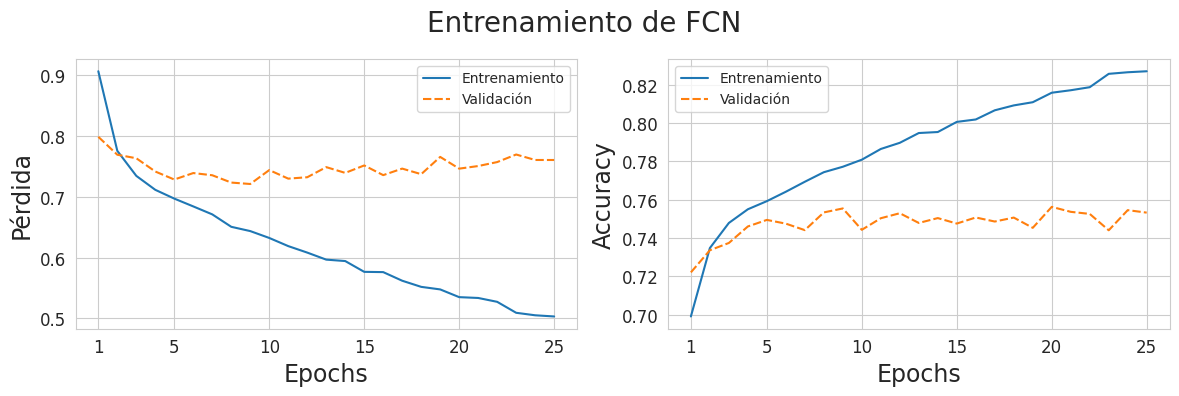

In [ ]:
plot_training_results(
    checkpoint["train_losses"],
    checkpoint["val_losses"],
    checkpoint["train_accuracies"],
    checkpoint["val_accuracies"],
    "Entrenamiento de FCN"
)

Medimos su *accuracy* exacta sobre el conjunto de validación y estimamos sus FPS:

In [ ]:
_ = measure_exact_accuracy_fcn(model, val_dataset, val_dataloader)

100%|██████████| 14/14 [00:10<00:00,  1.34it/s]



Accuracy: 0.7547


In [ ]:
_ = measure_fps_fcn(model, val_dataset, val_dataloader)

FPS: 25.11


La matriz de confusión la podemos encontrar, junto con la de U-Net, en unet.ipynb.